# MNIST DCGAN Example

Note: This notebook is desinged to run with Python3 and GPU runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_gpu.png)

This notebook uses TensorFlow 2.x.

In [0]:
%tensorflow_version 2.x

####[MDE-01]
Import modules and set a random seed.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.datasets import mnist

np.random.seed(20190615)
tf.random.set_seed(20190615)

####[MDE-02]
Download the MNIST dataset and store into NumPy arrays.

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11493376/11490434 [==============================] - 0s 0us/step


####[MDE-03]
Defina a generator model.

In [7]:
latent_dim = 64

generator = models.Sequential()
generator.add(
  layers.Dense(7*7*128, kernel_initializer=initializers.TruncatedNormal(),
               input_shape=(latent_dim,), name='expand'))
generator.add(layers.LeakyReLU(name='leaky_relu1'))
generator.add(layers.Reshape((7, 7, 128), name='reshape'))
generator.add(
  layers.Conv2DTranspose(64, 5, strides=2, padding='same',
                         kernel_initializer=initializers.TruncatedNormal(),
                         name='deconv1'))
generator.add(layers.LeakyReLU(name='leaky_relu2'))
generator.add(
  layers.Conv2DTranspose(1, 5, strides=2, padding='same',
                         kernel_initializer=initializers.TruncatedNormal(),
                         activation='sigmoid', name='deconv2'))
generator.add(layers.Flatten(name='flatten'))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand (Dense)               (None, 6272)              407680    
_________________________________________________________________
leaky_relu1 (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
deconv1 (Conv2DTranspose)    (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_relu2 (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 28, 28, 1)         1601      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0

####[MDE-04]
Defina a discriminator model.

In [8]:
discriminator = models.Sequential()
discriminator.add(layers.Reshape((28, 28, 1), input_shape=((28*28,)),
                                 name='reshape'))
discriminator.add(
  layers.Conv2D(64, (5, 5), strides=2, padding='same',
                kernel_initializer=initializers.TruncatedNormal(),
                name='conv1'))
discriminator.add(layers.LeakyReLU(name='leaky_relu1'))
discriminator.add(
  layers.Conv2D(128, (5, 5), strides=2, padding='same',
                kernel_initializer=initializers.TruncatedNormal(),
                name='conv2'))
discriminator.add(layers.LeakyReLU(name='leaky_relu2'))
discriminator.add(layers.Flatten(name='flatten'))
discriminator.add(layers.Dropout(rate=0.4, name='dropout'))
discriminator.add(layers.Dense(1, activation='sigmoid', name='sigmoid'))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_relu1 (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_relu2 (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)             

####[MDE-05]
Compile the discriminator using the Adam optimizer, and Cross entroy as a loss function.

In [0]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

####[MDE-06]
Define an end-to-end GAN model to train the generator.

In [10]:
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan_model = models.Model(gan_input, gan_output)
gan_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               614145    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 827,010
Trainable params: 614,145
Non-trainable params: 212,865
_________________________________________________________________


####[MDE-07]
Compile the GAN model using the Adam optimizer, and Cross entroy as a loss function.

In [0]:
gan_model.compile(optimizer='adam', loss='binary_crossentropy')

####[MDE-08]
Define some working variables to trace the training process.

In [0]:
batch_size = 32
image_num = 0
step = 0
examples = []
sample_inputs = np.random.rand(8, latent_dim) * 2.0 - 1.0
examples.append(generator.predict(sample_inputs))

####[MDE-09]
Train the model for 80,000 batches.

In [13]:
for _ in range(80000):
  random_inputs = np.random.rand(batch_size, latent_dim) * 2.0 - 1.0
  generated_images = generator.predict(random_inputs)
  real_images = train_images[image_num : image_num+batch_size]
  all_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.zeros((batch_size, 1)),
                           np.ones((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  d_loss = discriminator.train_on_batch(all_images, labels)

  random_inputs = np.random.rand(batch_size, latent_dim) * 2.0 - 1.0
  fake_labels = np.ones((batch_size, 1))
  g_loss = gan_model.train_on_batch(random_inputs, fake_labels)

  image_num += batch_size
  if image_num + batch_size > len(train_images):
    image_num = 0

  step += 1
  if step % 8000 == 0:
    print('step: {}, loss(discriminator, generator): {:6.4f}, {:6.4f}'.format(
            step, d_loss, g_loss))
    examples.append(generator.predict(sample_inputs))

W0827 02:35:54.942223 140281178097536 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0827 02:35:55.034563 140281178097536 deprecation.py:323] From /tensorflow-2.0.0b1/python3.6/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


step: 8000, loss(discriminator, generator): 0.5285, 1.0964
step: 16000, loss(discriminator, generator): 0.5608, 0.7941
step: 24000, loss(discriminator, generator): 0.4893, 1.7355
step: 32000, loss(discriminator, generator): 0.4984, 0.9463
step: 40000, loss(discriminator, generator): 0.4629, 1.3208
step: 48000, loss(discriminator, generator): 0.3526, 1.6230
step: 56000, loss(discriminator, generator): 0.3932, 0.6275
step: 64000, loss(discriminator, generator): 0.4767, 0.7077
step: 72000, loss(discriminator, generator): 0.5279, 0.9530
step: 80000, loss(discriminator, generator): 0.3523, 1.1203


####[MDE-10]
Show the progress of sample images.

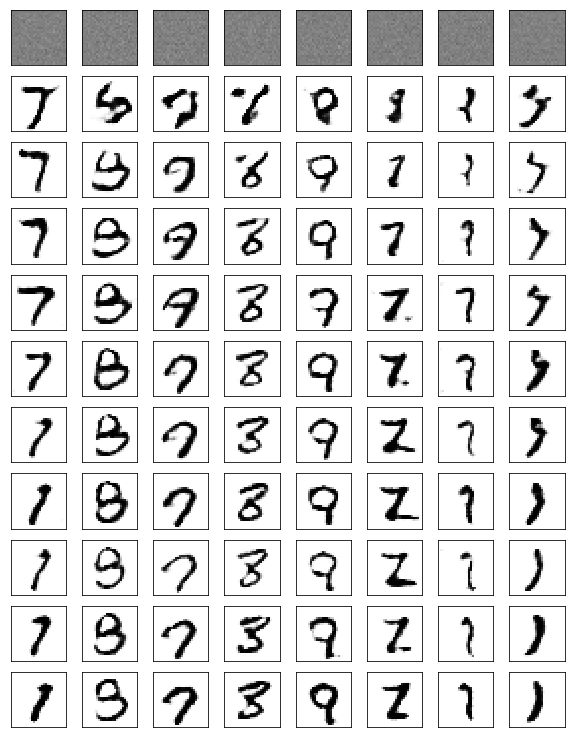

In [14]:
def show_images(examples):
  fig = plt.figure(figsize=(10, 1.2*len(examples)))
  c = 1
  for images in examples:
    for image in images:
      subplot = fig.add_subplot(len(examples), 8, c)
      subplot.set_xticks([])
      subplot.set_yticks([])
      subplot.imshow(image.reshape((28, 28)),
                     vmin=0, vmax=1, cmap=plt.cm.gray_r)
      c += 1

show_images(examples)

####[MDE-10]
Mount your Google Drive on `/content/gdrive`.

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####[MDE-11]
Export the trained model as a file `gan_generator.hd5` on your Google Drive.

In [0]:
generator.save('/content/gdrive/My Drive/gan_generator.hd5', save_format="h5")